In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
from sklearn import datasets
%matplotlib inline
sess = tf.Session()

In [2]:
#Load iris dataset, split apart the targets for each class. We will only use sepal length and petal width to illustrate.
#We also separate the x and y values for each class for plotting purposes at the end. 
iris = datasets.load_iris()
x_vals = iris.data[:,[0,3]]
y_vals1 = np.array([1 if y==0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y==1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y==2 else -1 for y in iris.target])
y_vals = np.array([y_vals1, y_vals2, y_vals3])
class1_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==0]
class1_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==0]
class2_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==1]
class2_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==1]
class3_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==2]
class3_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==2]

In [3]:
#Since we now have 3 classifiers instead of 1, we will make us of matrix broadcasting and reshaping techniques to 
#calculate all 3 SVMs at once.
batch_size = 50

x_data = tf.placeholder(dtype=tf.float32, shape=[None,2])
y_target = tf.placeholder(dtype=tf.float32, shape=[3,None])
prediction_grid = tf.placeholder(dtype=tf.float32, shape=[None,2])

b = tf.Variable(tf.random_normal(shape=[3,batch_size]))

In [4]:
#calculate Gaussian Kernel. 
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))),tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

In [5]:
#One big change, this time, is that we will do batch matrix multiplication. We will end up with 3-dimensional
#matrices and we will want to broadcast matrix multiplication across the third index. 
def reshape_matmul(mat):
    v1 = tf.expand_dims(mat,1)
    v2 = tf.reshape(v1, [3,batch_size,1])
    return(tf.matmul(v2,v1))

In [6]:
#compute dual loss function. 
model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b),b)
y_target_cross = reshape_matmul(y_target)

second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)),[1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term,second_term)))

In [7]:
#prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid),1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

In [8]:
prediction_output = tf.matmul(tf.multiply(y_target,b),pred_kernel)
prediction = tf.argmax(prediction_output-tf.expand_dims(tf.reduce_mean(prediction_output,1),1),0)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target,0)),tf.float32))

In [9]:
#declare optimizer
opt = tf.train.GradientDescentOptimizer(0.01)
train_step = opt.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [10]:
#train
loss_vec = []
batch_accuracy = []
for i in range(100):
    rand_index = np.random.choice(len(x_vals),batch_size)
    rand_x = x_vals[rand_index]
    rand_y = y_vals[:,rand_index]
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data:rand_x, y_target:rand_y, prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if(i+1)%20 == 0:
        print('Step # ' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step # 20
Loss = 0.15529442
Step # 40
Loss = -23.39801
Step # 60
Loss = -25.206085
Step # 80
Loss = -26.2216
Step # 100
Loss = -25.468863


In [11]:
#create prediction grid of points and run the prediction function on all of them
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = sess.run(prediction, feed_dict={x_data:rand_x,y_target:rand_y, prediction_grid:grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

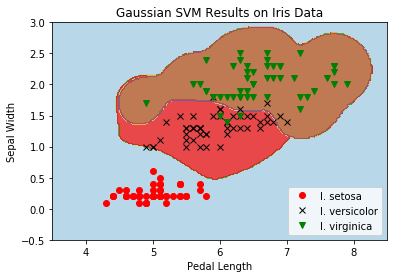

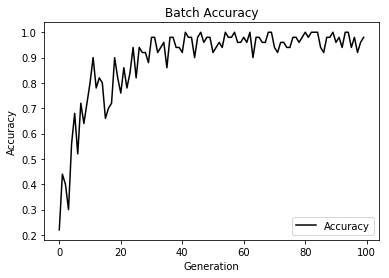

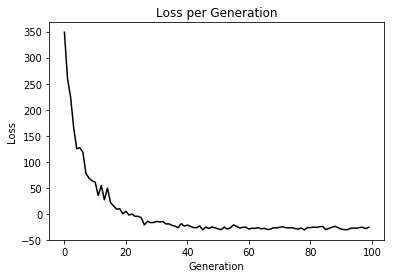

In [14]:
#plot 
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired,alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='I. versicolor')
plt.plot(class3_x, class3_y, 'gv', label='I. virginica')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5,3])
plt.xlim([3.5,8.5])
plt.show()

plt.plot(batch_accuracy,'k-',label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()